In [1]:
import numpy as np
import networkx as nx
import scipy.linalg as la
import matplotlib.pyplot as plt
import nb_general as nb
from scipy.stats import kendalltau as kt
from scipy.optimize import curve_fit

# Bahmini Algorithm

In [2]:
class PageRankAlg:
    """
    Class that creates graphs and tests pagerank algorithms
    with and without non-backtracking condition
    
    Attributes:
        self.G: Networkx Graph
        self.node_dict: Dictionary of nodes and who they point to
        self.alpha: alpha parameter for PageRank
    """
    def __init__(self,G=None,n=100,p=.7,alpha=.85):
        """
        Initialize PageRankAlg object
        Parameters:
            G: Networkx Graph
            n: number of vertices in random graph
            p: probability for Erdos-Renyi random graph
            alpha: alpha parameter for pagerank
            PageRankStore: dictionary to store walk segments
            nbPageRankStore: dictionary to store walk segments
                             for non-backtracking alg.
        """
        
        if G is None: # Create random graph if no graph given
            self.G = nx.gnp_random_graph(n,p)
        else:
            self.G = G
                
        # Get rid of all degree 1 vertices
        remove = [node for node in self.G.nodes if self.G.degree(node) < 2]
        while len(remove) > 0:
            self.G.remove_nodes_from(remove)
            remove = [node for node in self.G.nodes if self.G.degree(node) < 2]
        
        # Check to see that Graph is valid
        if len(self.G.nodes) == 0:
            raise ValueError('Invalid graph. Must be at least degree 2')
        
        # Create dictionary of markov chain
        self.node_dict = dict()
        for v in self.G.nodes:
            self.node_dict[v] = list(self.G.neighbors(v))
        
        # Alpha parameter
        self.alpha = alpha
        
        # Create PageRankStore for approximate pagerank
        self.PageRankStore = None
            
        # Create nbPageRankStore for approximate pagerank
        self.nbPageRankStore = None
    
    def pagerank(self):
        """
        Compute naive pagerank
        """
        return nx.pagerank(self.G,alpha=self.alpha)
    
    def nb_pagerank(self,edge=False):
        """
        Compute pagerank nonbacktracking
        
        Parameters:
            edge (bool): if False, compute using algorithm
                         with uniform distribution in degree
                         space. if True, compute using 
                         uniform distribution in edge space
        """
        if edge: # Edge uniform distribution
            C, B = nb.to_edge_space(self.G, B=True)
            S, T = nb.create_s_t(self.G)
            
            # Get ranking
            ranking = nx.pagerank(B,alpha=self.alpha)
            ranking = np.array(list(ranking.values()))
            # Project to vertex space
            vertex_rank = T@ranking
            
             # Create output like networkx
            sol = dict()
            for i in range(len(vertex_rank)):
                sol[i] = vertex_rank[i]

            return sol
        
        # Vertex uniform distribution
        C, B = nb.to_edge_space(self.G, B=True, graph=False)
        S, T = nb.create_s_t(self.G)

        # Get edge degree matrix
        D = np.diag(B.sum(axis=1))
        D_inv = la.solve(D,np.eye(D.shape[0]))
        TT_inv = la.solve(T@T.T,np.eye(T.shape[0]))

        # Make equation to solve
        lhs = np.eye(B.shape[0])-self.alpha*B.T@D_inv
        rhs = (1-self.alpha)/len(self.G.nodes)*T.T@TT_inv@np.ones(T.T.shape[1])

        pr_vec = T@la.solve(lhs,rhs)

        # Create output like networkx
        sol = dict()
        for i in range(len(pr_vec)):
            sol[i] = pr_vec[i]

        return sol
        
    def rank(self):
        """
        Computes standardize ranking of vector which accounts for ties

        Parameters:
            x (ndarray)

        Returns:
            pr_rank (ndarray)
            nb_pr_rank (ndarray)
            nb_pr_rank_edge (ndarray)
        """
        def get_rank(x):
            # Create ranking array and sorted array
            copy = np.copy(x)
            sorted_x = np.sort(copy)
            cur_rank = np.zeros_like(copy)
            # Check rank of each node
            for i, val in enumerate(copy):
                # Account for ties by using np.min
                cur_rank[i] = np.min(np.where(np.around(sorted_x,decimals=12)==round(val,12))[0])

            return cur_rank

        pr = np.array(list(dict(self.pagerank()).values()))
        nb_pr = np.array(list(dict(self.nb_pagerank()).values()))
        nb_pr_edge = np.array(list(dict(self.nb_pagerank(edge=True)).values()))

        return get_rank(pr), get_rank(nb_pr), get_rank(nb_pr_edge)
    
    def kendall_tau(self,x,y):
        """
        Get kendall tau metric of two rankings
        
        Parameters:
            x (dict): first ranking
            y (dict): second ranking
        
        Return:
            kt (correlation, pvalue)
        """
        # Make dictionaries array
        x_arr = np.array(list(dict(x).values()))
        y_arr = np.array(list(dict(y).values()))
        
        def get_rank(x):
            # Create ranking array and sorted array
            copy = np.copy(x)
            sorted_x = np.sort(copy)
            cur_rank = np.zeros_like(copy)
            # Check rank of each node
            for i, val in enumerate(copy):
                # Account for ties by using np.min
                cur_rank[i] = np.min(np.where(np.around(sorted_x,decimals=12)==round(val,12))[0])

            return cur_rank
        
        return kt(get_rank(x_arr),get_rank(y_arr))
    
    def bahmini_alg(self,R,normalize=True):
        """
        Implementation of Bahmini Algorithm

        Parameter:
            R (int): number of random walks from each node

        Returns:
            pr (ndarray): approximated pagerank vector
        """
        # Initialize self.PageRankStore
        self.PageRankStore = dict()
        for i in self.G.nodes: # Initialize
            self.PageRankStore[i] = []
                
        # Initialize pr vector
        pr = np.zeros(len(self.G.nodes))
            
        # Take R random walks for each node
        for n in self.G.nodes:
            for _ in range(R):
                seg = [n]
                u = n
                while True:
                    beta = np.random.uniform()
                    if beta > self.alpha: # End if teleporting
                        for v in seg: # THIS MAKES IT O(nR/alpha^2)!!!
                            self.PageRankStore[v].append(seg)
                        break
                    else:
                        neigh = self.node_dict[u] # Get all neighbors of current node
                        u = np.random.choice(neigh)
                        seg.append(u) # Take step along chain
        
        # Approximate pagerank function
        def approx(Xv):
            """
            Approximate pagerank of a given node v
            
            Parameters:
                Xv (int): number of walk lengths containing v
            
            Returns:
                pi_v (float): approximate pagerank value
            """
            return Xv/(self.G.number_of_nodes()*R/self.alpha)
            
        for i in range(len(self.G.nodes)):
            # Approximate pagerank of node i
            pr[i] = approx(len(self.PageRankStore[list(self.G.nodes)[i]]))
        
        if normalize:
            pr /= np.sum(pr)
            
        # Make pagerank vector return like networkx
        sol = dict()
        for i in range(len(pr)):
            sol[i] = pr[i]
            
        return sol
    
    def nb_bahmini_alg(self,R,normalize=True):
        """
        Implementation of Bahmini Algorithm with
        non-backtracking condition

        Parameter:
            R (int): number of random walks from each node

        Returns:
            pr (ndarray): approximated pagerank vector
        """
        # Initialize self.nbPageRankStore
        self.nbPageRankStore = dict()
        for i in self.G.nodes: # Initialize
            self.nbPageRankStore[i] = []
                
        # Initialize pr vector
        pr = np.zeros(len(self.G.nodes))
            
        # Take R random walks for each node
        for n in self.G.nodes:
            for _ in range(R):
                seg = [n]
                u = n
                beta = np.random.uniform()
                if beta > self.alpha: # End if teleporting
                    for v in seg: # THIS MAKES IT O(nR/alpha^2)!!!
                        self.nbPageRankStore[v].append(seg)
                    continue
                else:
                    neigh = self.node_dict[u] # Get all neighbors of current node
                    u = np.random.choice(neigh)
                    seg.append(u)
                    last = n
                while True:
                    beta = np.random.uniform()
                    if beta > self.alpha: # End if teleporting
                        for v in seg: # THIS MAKES IT O(nR/alpha^2)!!!
                            self.nbPageRankStore[v].append(seg)
                        break
                    else:
                        neigh = np.copy(self.node_dict[u]) # Get all neighbors of current node
                        hold = u # Keep track of last node
                        u = np.random.choice(neigh[neigh!=last]) # Non-backtracking condition
                        last = hold 
                        seg.append(u) # Take step along chain
        
        # Approximate pagerank function
        def approx(Xv):
            """
            Approximate pagerank of a given node v
            
            Parameters:
                Xv (int): number of walk lengths containing v
            
            Returns:
                pi_v (float): approximate pagerank value
            """
            return Xv/(self.G.number_of_nodes()*R/self.alpha)
            
        for i in range(len(self.G.nodes)):
            # Approximate pagerank of node i
            pr[i] = approx(len(self.nbPageRankStore[list(self.G.nodes)[i]]))
        
        if normalize:
            pr /= np.sum(pr)
            
        # Make pagerank vector return like networkx
        sol = dict()
        for i in range(len(pr)):
            sol[i] = pr[i]
            
        return sol
        

In [3]:
G = nx.Graph([[1,2],[2,3],[3,4],[4,1],[1,4],[4,5],[5,3]])
test = PageRankAlg(G)

/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


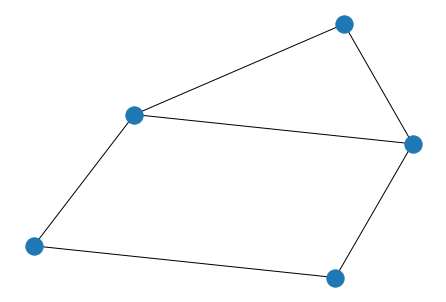

In [4]:
nx.draw(G)
plt.savefig('example_graph.pdf')
plt.show()

In [4]:
bah = test.bahmini_alg(10000)
pr = test.pagerank()

In [5]:
test.kendall_tau(bah,pr)

KendalltauResult(correlation=0.8944271909999159, pvalue=0.03671385636270413)

In [330]:
bah

{0: 0.17189394782849424,
 1: 0.17195412951701186,
 2: 0.24374486574969834,
 3: 0.2440307287701571,
 4: 0.16837632813463846}

In [331]:
pr

{1: 0.1722562971205864,
 2: 0.1722562971205864,
 3: 0.24369622576677996,
 4: 0.24369622576677996,
 5: 0.16809495422526696}

In [5]:
def pr_alg_test(R_list,G=None,pr_vec = None,nb_vec=None):
    """
    Compare accuarcy for various values of R in 
    Bahmini alg with and without non-backtracking
    condition
    
    Parameters:
        R_list (ndarray): array of R values to test
        G (networkx graph)
        pr_vec (ndarray): pagerank vector
        nb_vec (ndarray): nb pagerank vector
        
    Returns:
        bac_acc (ndarray): array of KT correlations for simple
                           random walks
        nb_bah_acc (ndarray): array of KT correlations for 
                              non-backtracking random walks
    """
    # Create random graph if none given
    if G is None:
        G = nx.gnp_random_graph(100,.7)
        
    # Initialize object and accuracy lists
    g = PageRankAlg(G)
    bah_acc = []
    nb_acc = []
    
    # Get original pagerank
    if pr_vec is None:
        pr = g.pagerank()
    else:
        pr = pr_vec
    if nb_vec is None:
        nb_pr_v = g.nb_pagerank()
    else:
        nb_pr_v = nb_vec
    pr = np.array(list(pr.values()))
    nb_pr_v = np.array(list(nb_pr_v.values()))

    for i, r in enumerate(R_list):
        # Calculate accuracy of bahmini and nb bahmini
        bah = np.array(list(g.bahmini_alg(r).values()))
        nb_bah = np.array(list(g.nb_bahmini_alg(r).values()))
        bah_acc.append(la.norm(bah-pr,ord=np.inf))
        nb_acc.append(la.norm(nb_bah-nb_pr_v,ord=np.inf))
    
    # Plot R vs. accuracy
    plt.plot(R_list,bah_acc,'-o',label='Simple Random Walk')
    plt.plot(R_list,nb_acc,'-o',label='Non-backtracking Random Walk')
    plt.legend()
    plt.xlabel('R')
    plt.ylabel('Error')
    plt.title('Bahmini Algorithm (Large n)')
#     plt.savefig('bahmini_karate.pdf')
    plt.show()
    
    return bah_acc, nb_acc

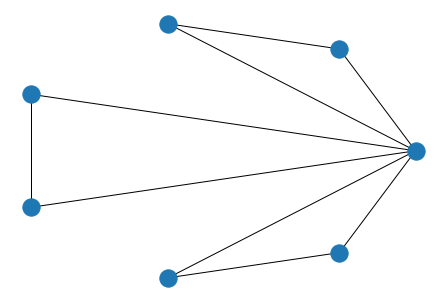

In [6]:
G=nx.Graph([[1,2],[2,3],[3,1],[4,1],[4,5],[5,1],[6,1],[6,7],[7,1]])
nx.draw_circular(G)
# plt.savefig('karate_graph.pdf')
plt.show()

In [25]:
G = nx.complete_graph(20)
R_list = [i for i in range(1,21)]
test = PageRankAlg(G)
nb_vec = test.nb_pagerank()

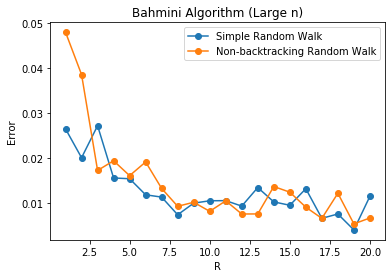

([0.026502732240437178,
  0.02008547008547007,
  0.02721518987341771,
  0.015576592082616157,
  0.015404475043029268,
  0.011827956989247317,
  0.011309523809523797,
  0.007380457380457367,
  0.009965928449744456,
  0.010495626822157447,
  0.010526315789473675,
  0.009305993690851742,
  0.013442537701508078,
  0.010247444862829504,
  0.009494298463063981,
  0.013177746346063182,
  0.006586270871985177,
  0.007551020408163273,
  0.004003021148036266,
  0.011490896599106855],
 [0.04803921568627449,
  0.038607594936708865,
  0.017248908296943304,
  0.01940726577437863,
  0.01609195402298852,
  0.019144460028050442,
  0.013243243243243254,
  0.009262851600387943,
  0.010164083865086639,
  0.008143074581430723,
  0.010483870967741955,
  0.0075500303214069905,
  0.00756256800870507,
  0.013674321503131512,
  0.012410671748451639,
  0.009069767441860443,
  0.006580732700135712,
  0.012164579606440074,
  0.005349029326724514,
  0.006663055254604623])

In [21]:
pr_alg_test(R_list,G)

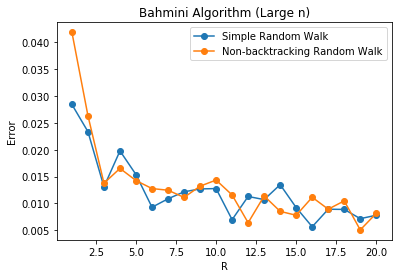

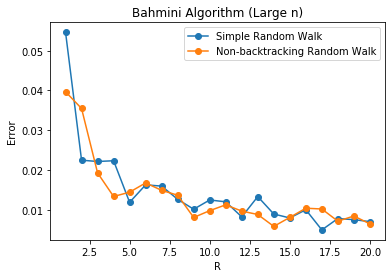

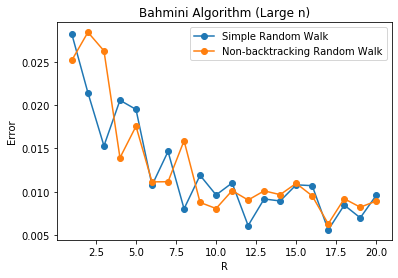

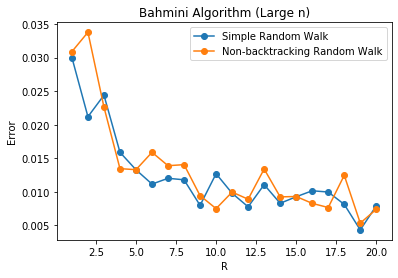

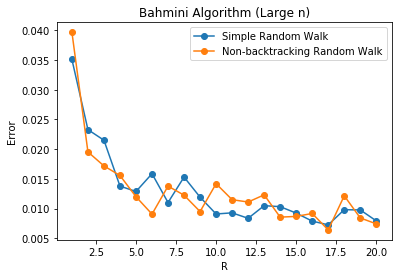

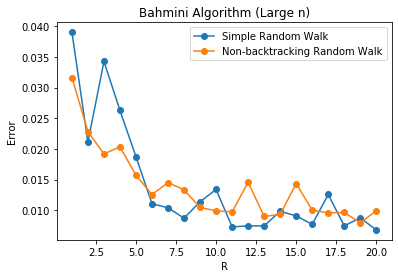

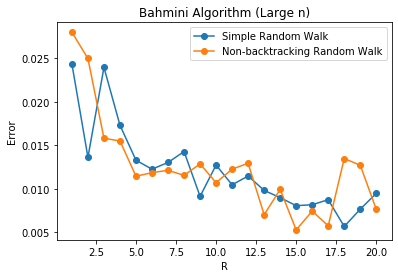

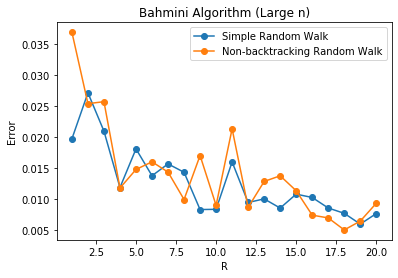

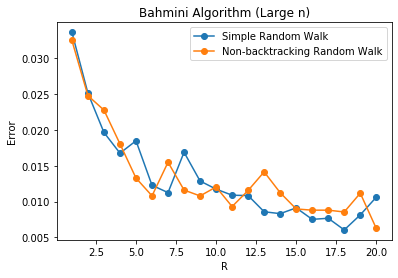

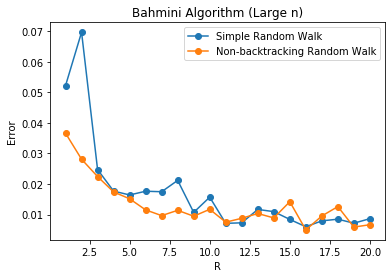

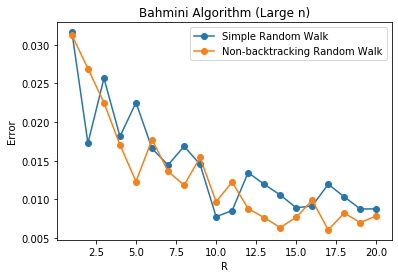

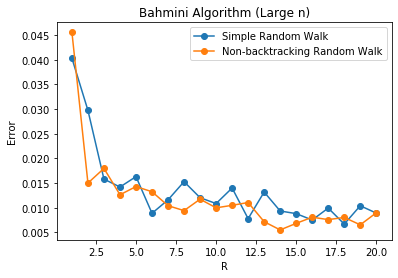

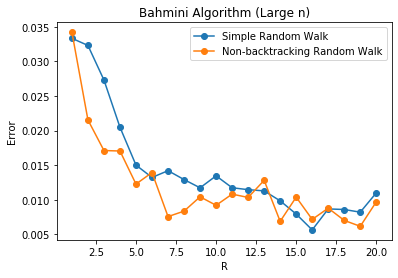

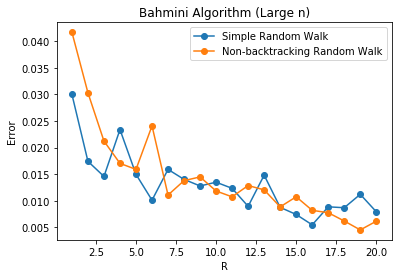

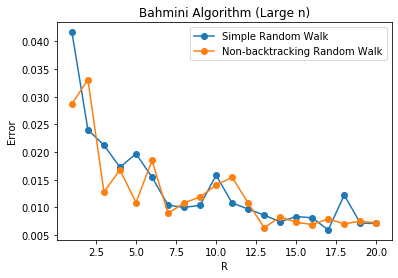

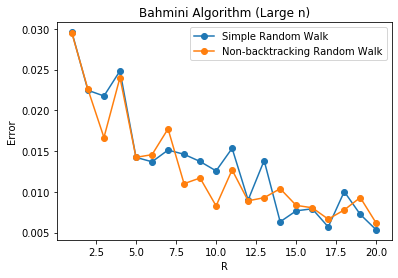

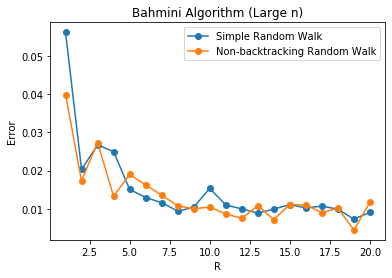

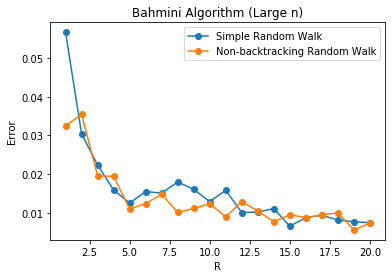

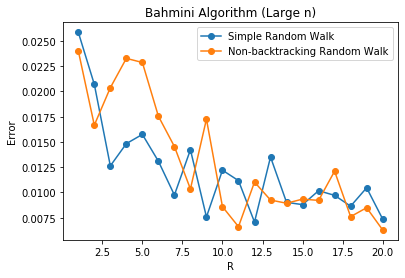

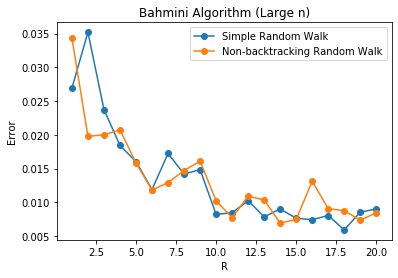

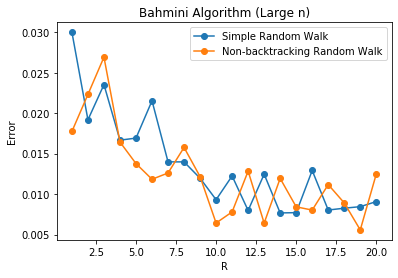

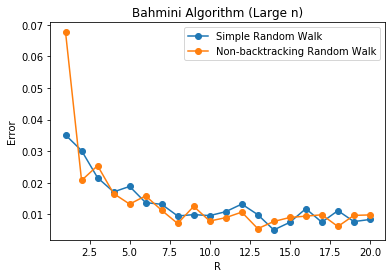

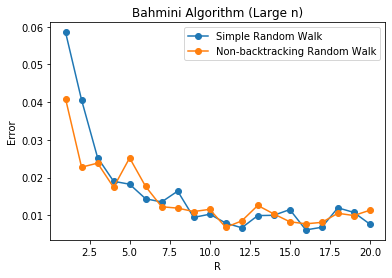

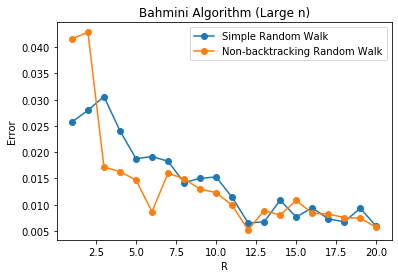

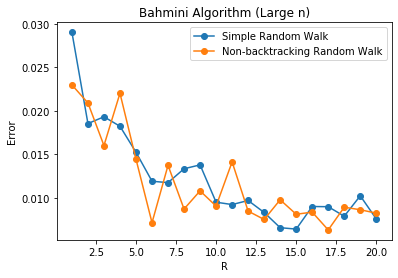

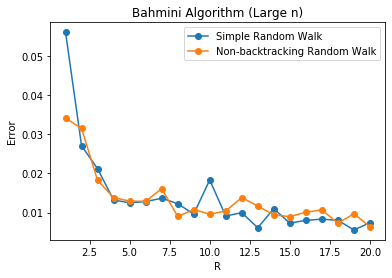

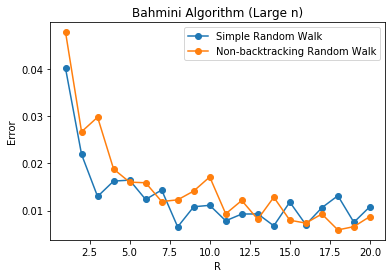

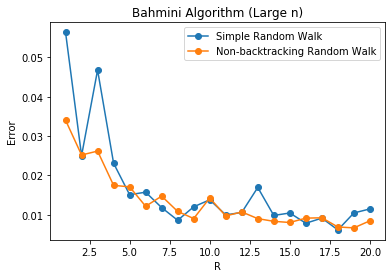

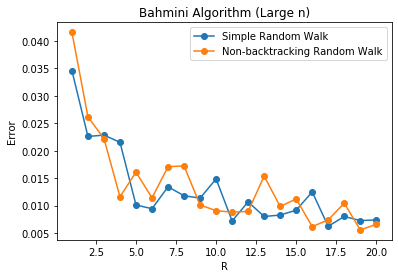

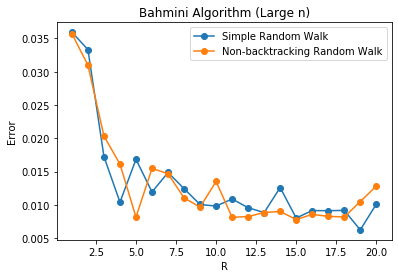

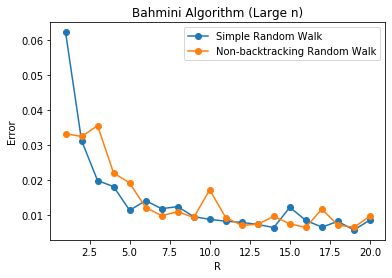

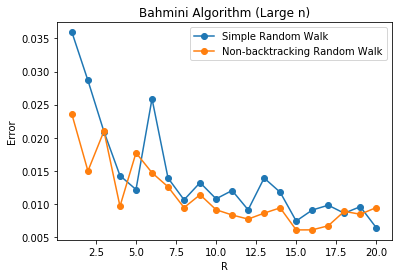

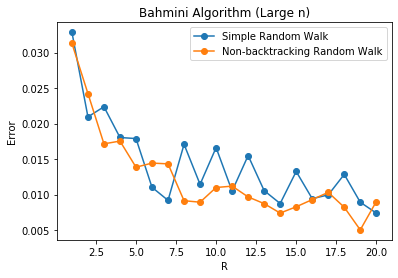

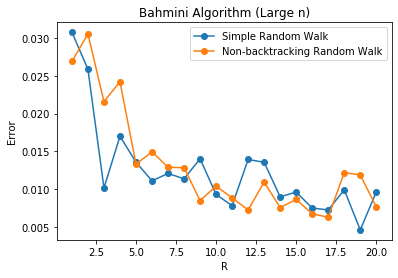

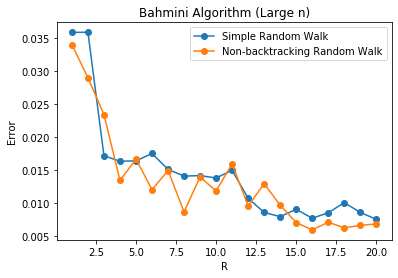

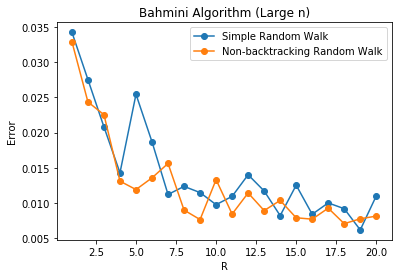

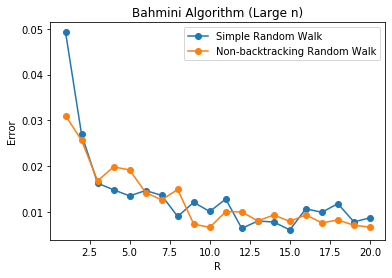

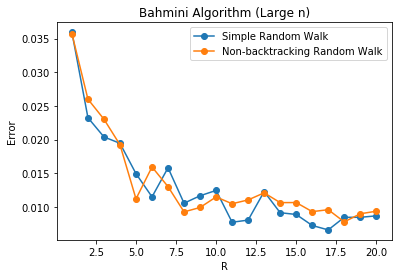

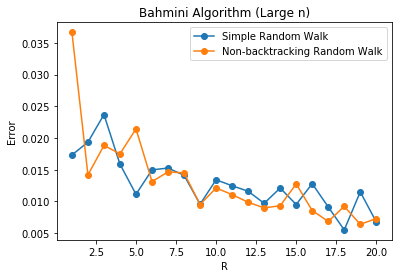

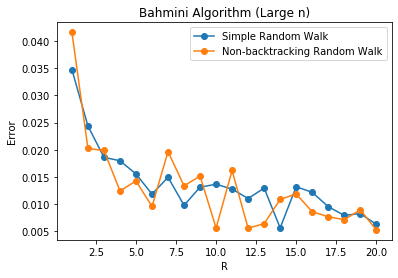

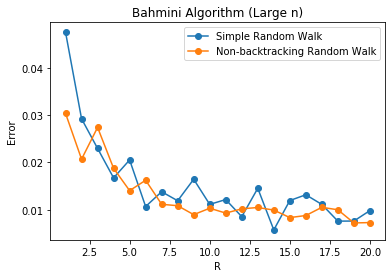

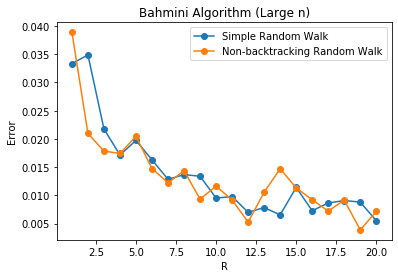

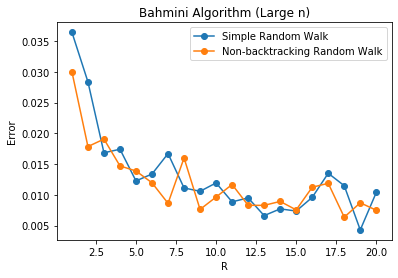

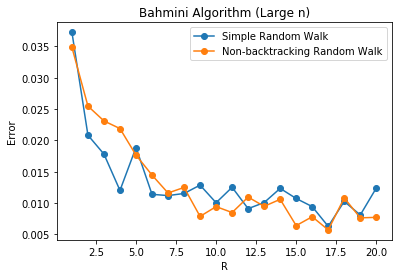

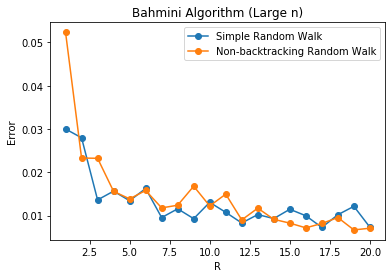

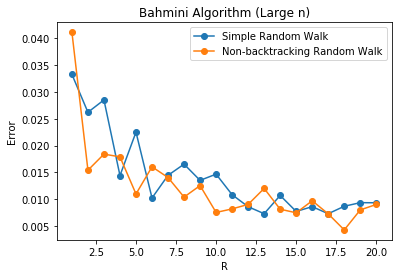

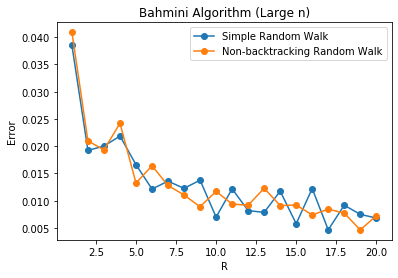

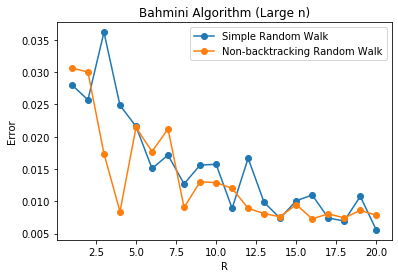

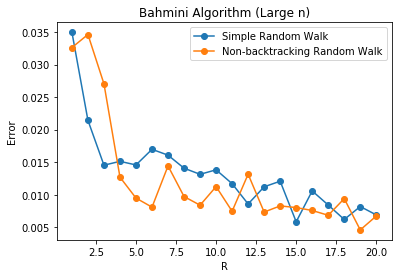

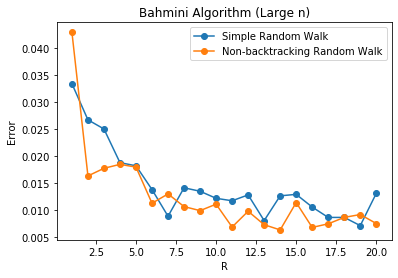

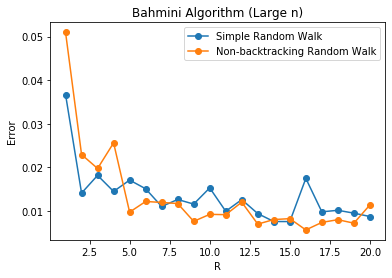

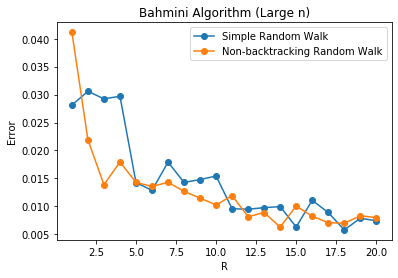

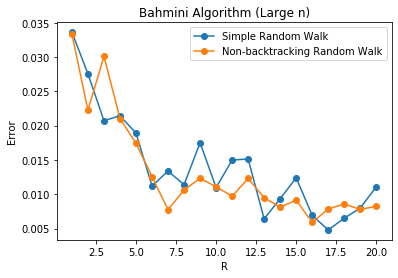

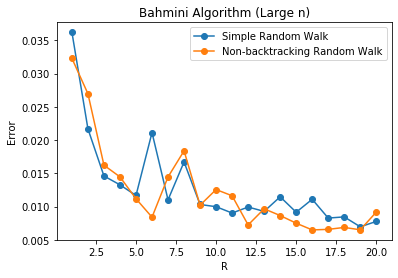

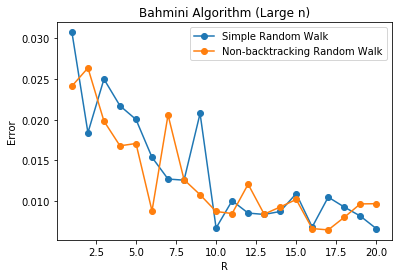

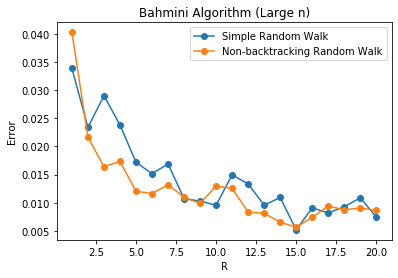

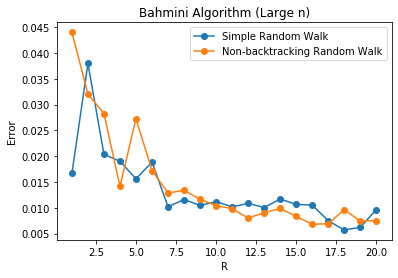

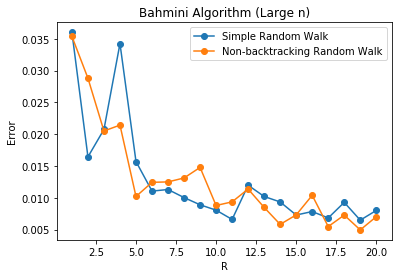

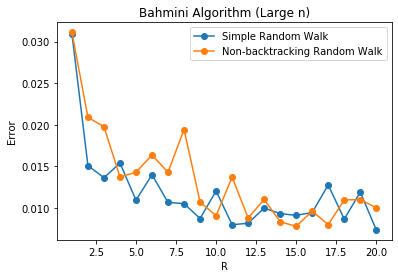

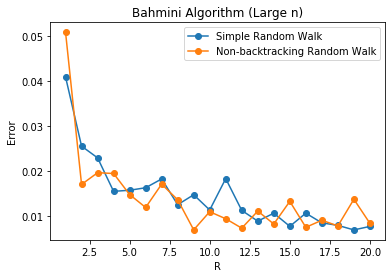

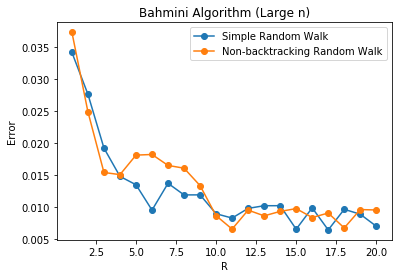

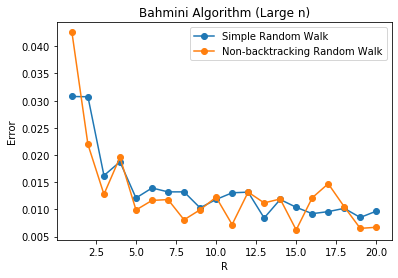

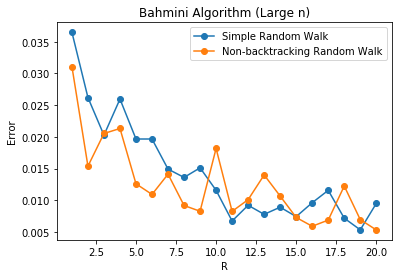

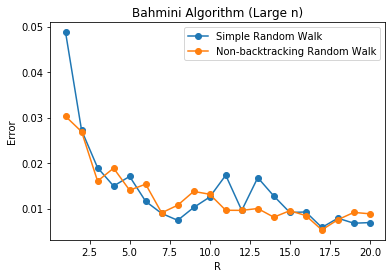

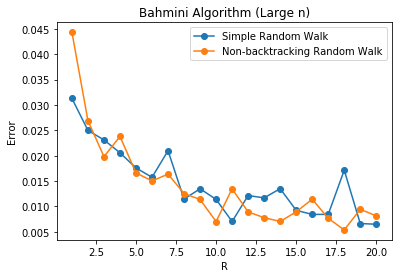

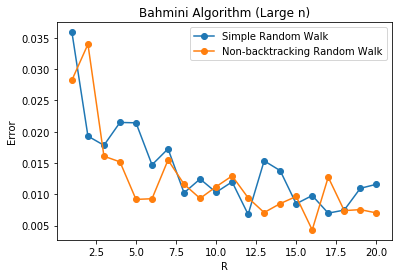

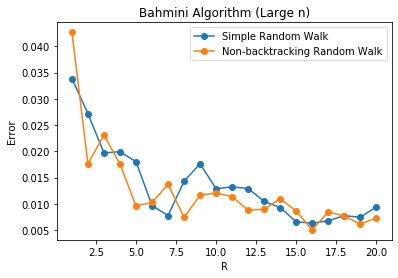

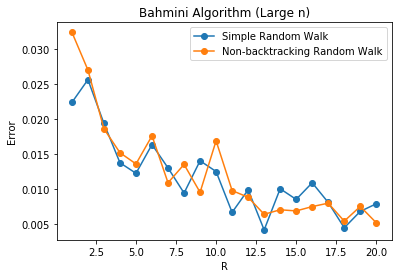

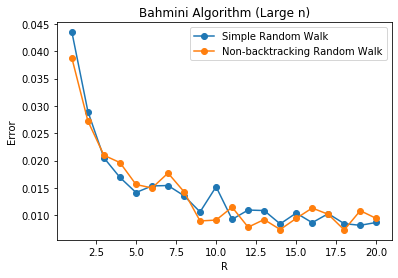

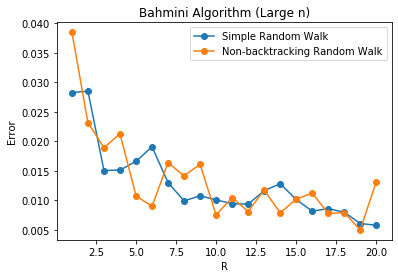

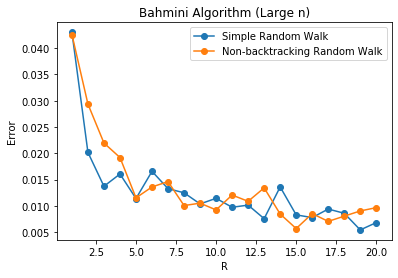

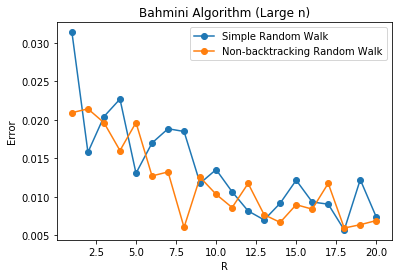

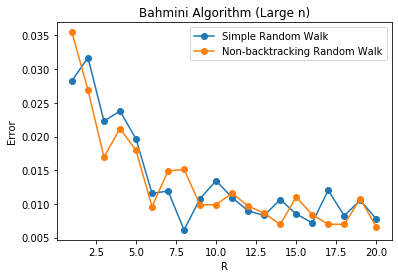

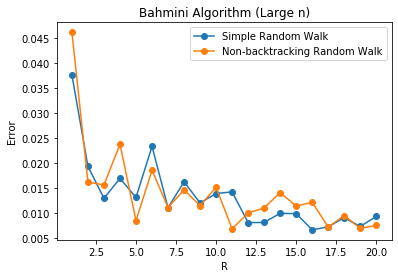

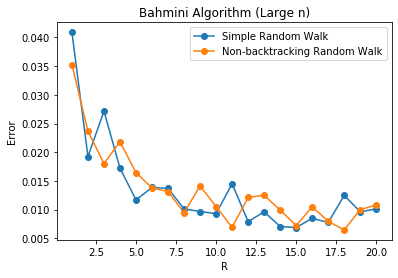

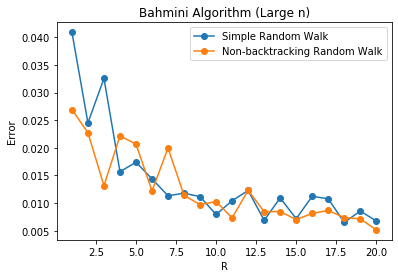

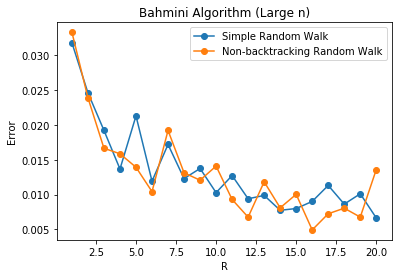

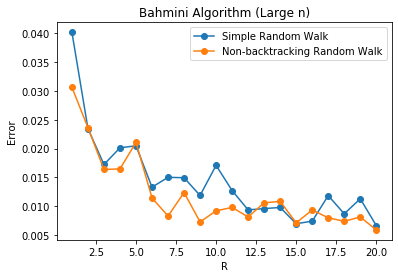

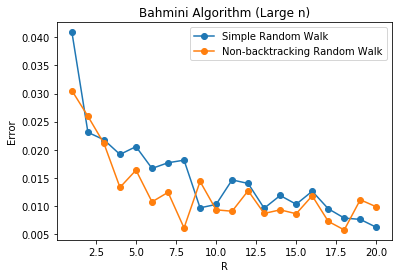

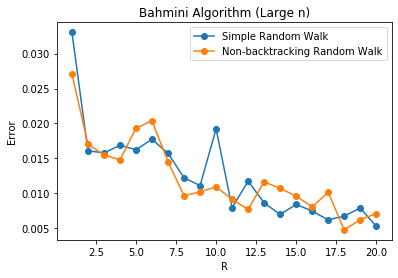

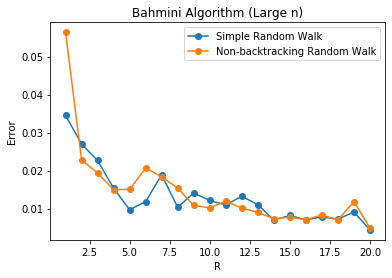

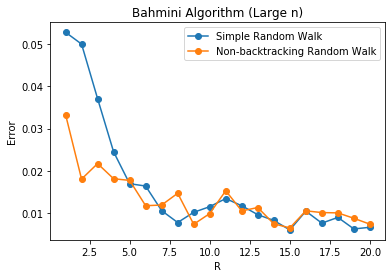

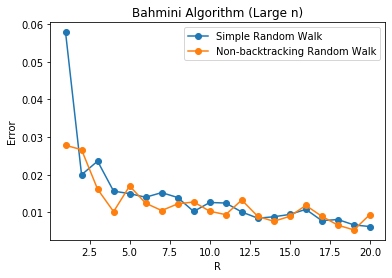

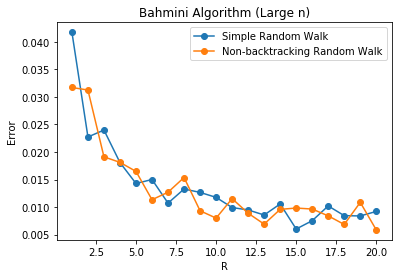

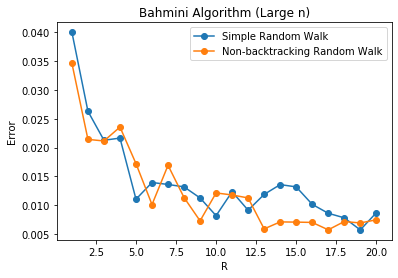

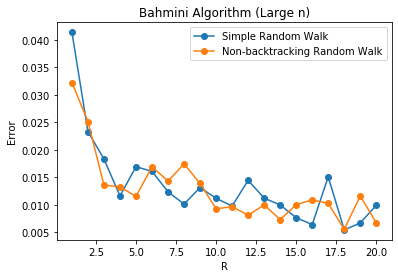

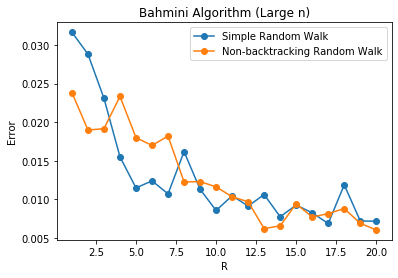

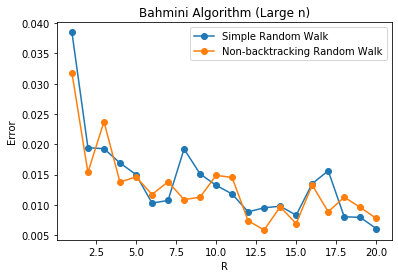

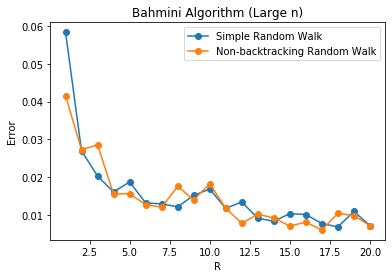

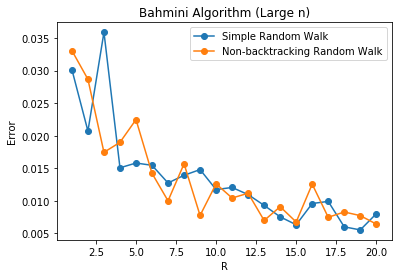

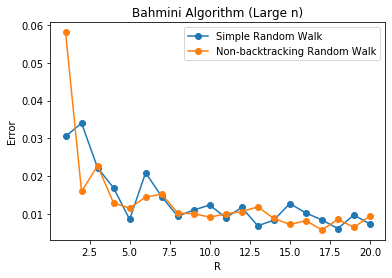

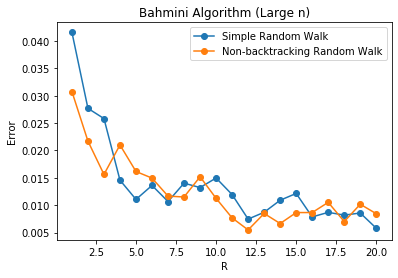

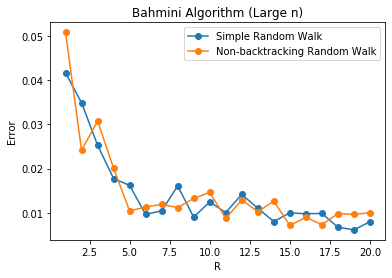

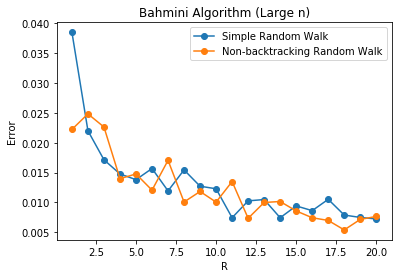

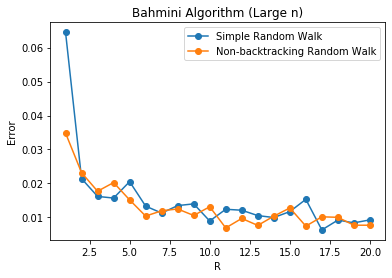

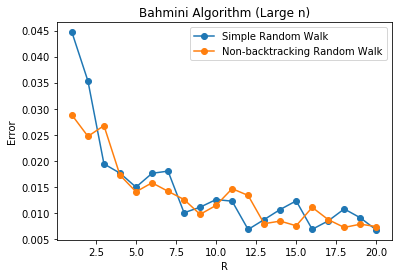

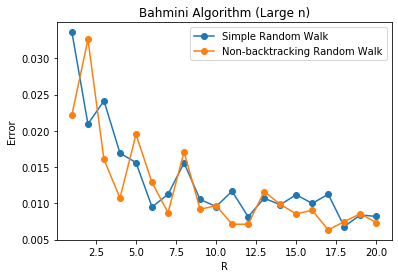

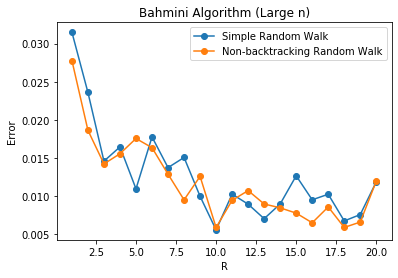

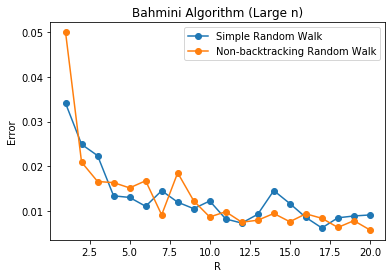

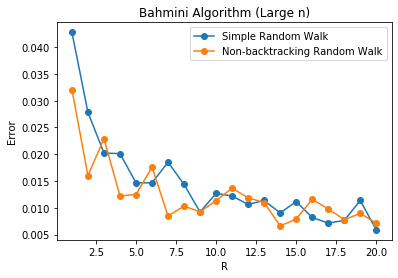

In [26]:
pr_array = np.zeros((20,100))
nb_array = np.zeros((20,100))
for i in range(100):
    pr, nb_pr = pr_alg_test(R_list,G,nb_vec=nb_vec)
    pr_array[:,i] = pr
    nb_array[:,i] = nb_pr

In [67]:
alpha = 1+20*np.sum([np.log(avg_pr[i]/(avg_pr[0]-1/2)) for i in range(0,20)])**(-1)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


In [68]:
alpha

nan

In [90]:
G = nx.karate_club_graph()

In [91]:
# Calculate nb
obj_G = PageRankAlg(G)
nb_vec = obj_G.nb_pagerank()

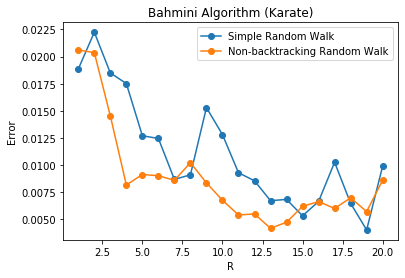

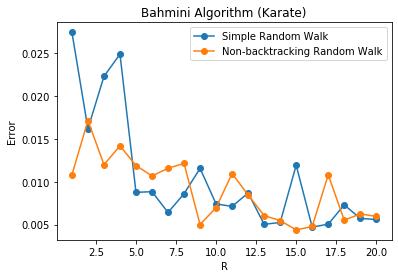

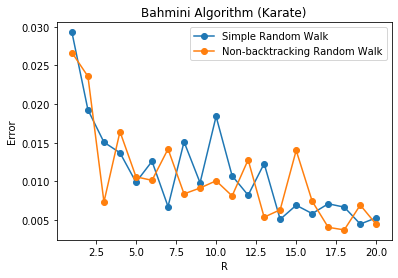

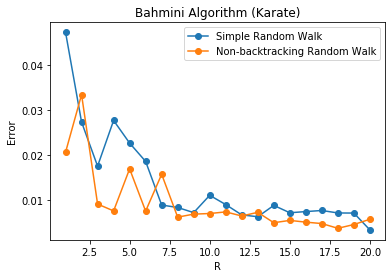

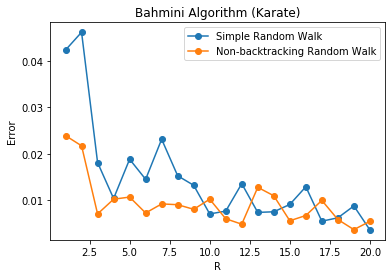

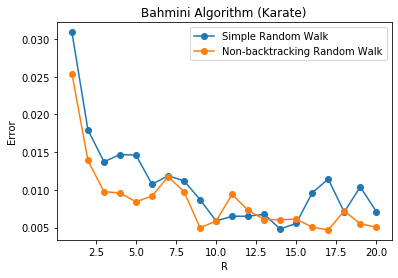

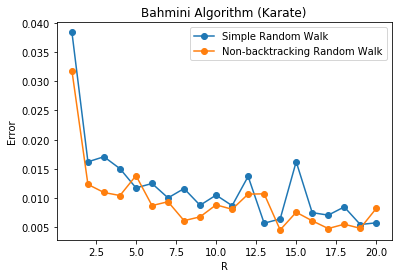

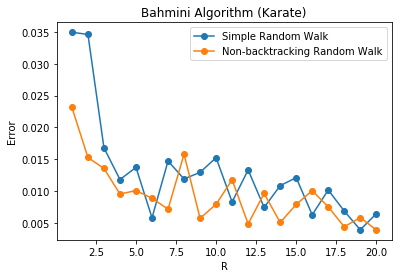

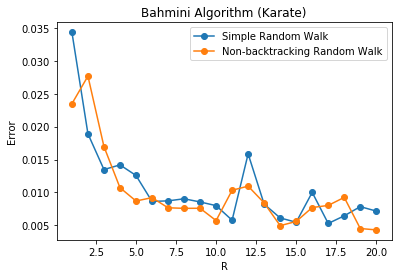

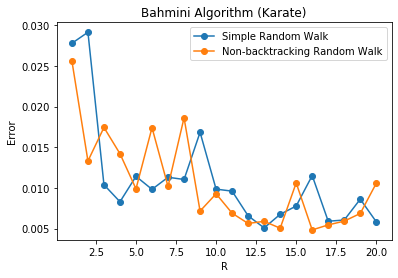

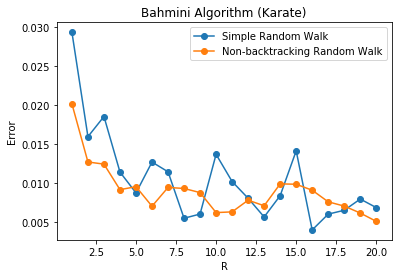

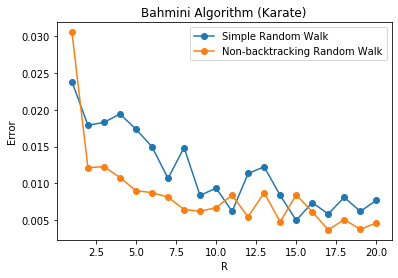

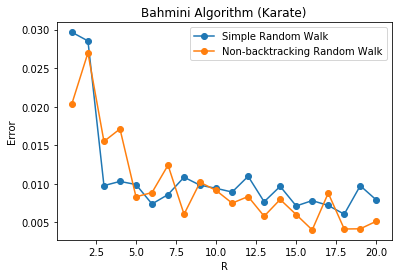

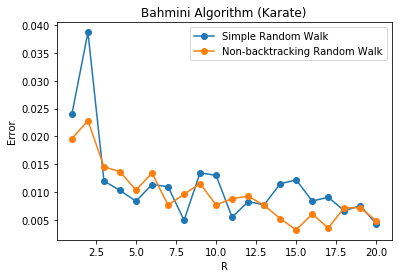

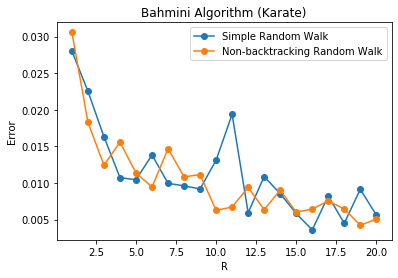

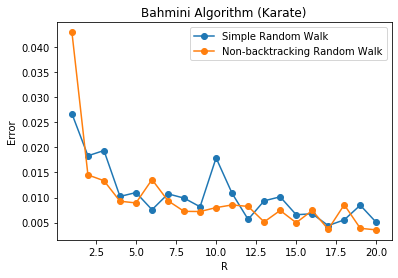

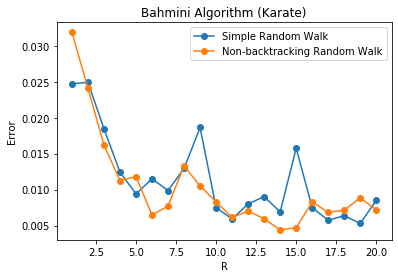

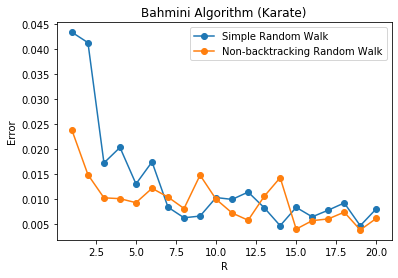

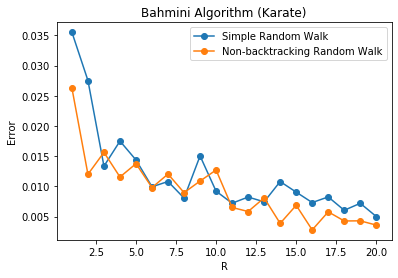

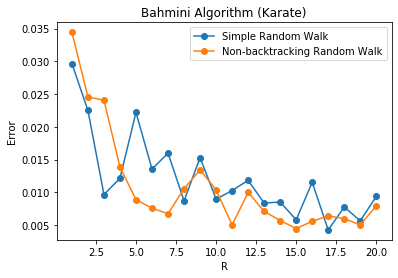

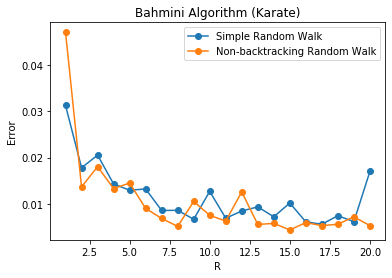

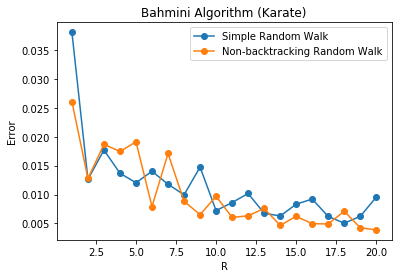

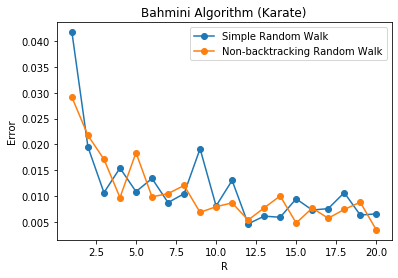

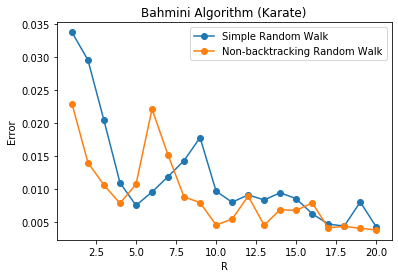

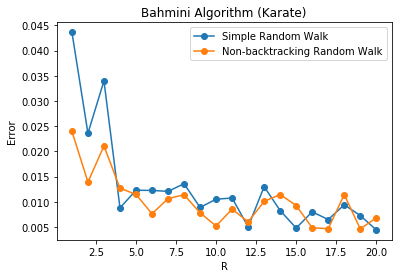

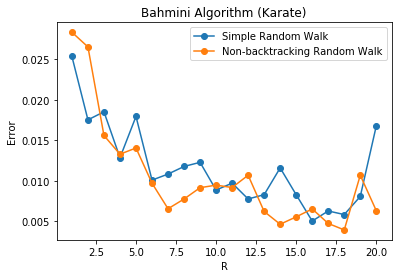

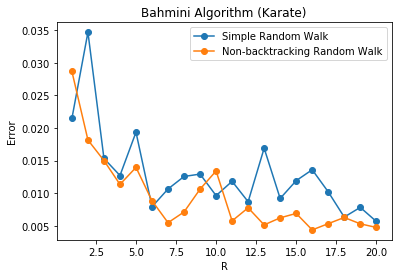

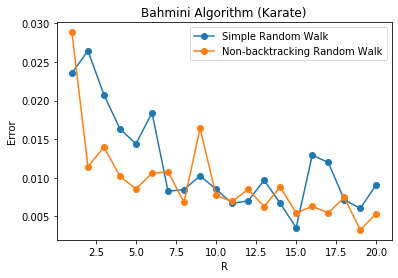

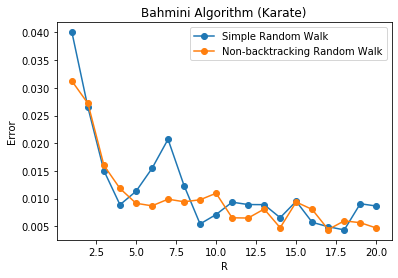

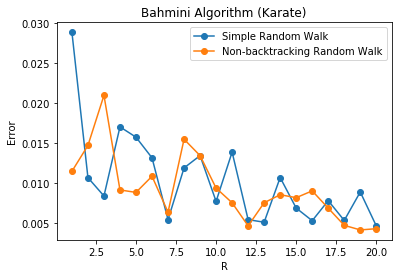

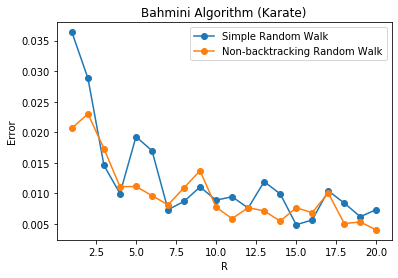

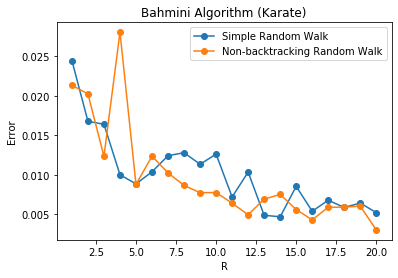

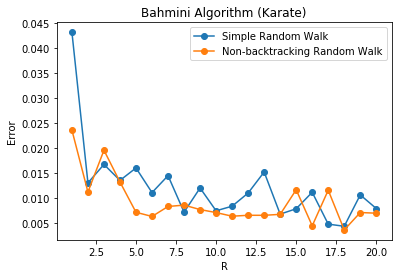

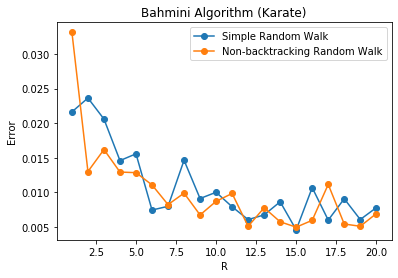

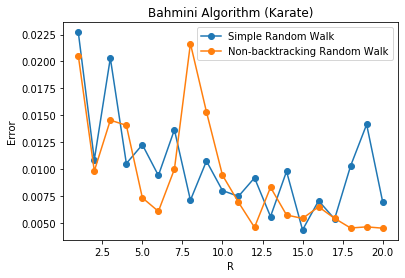

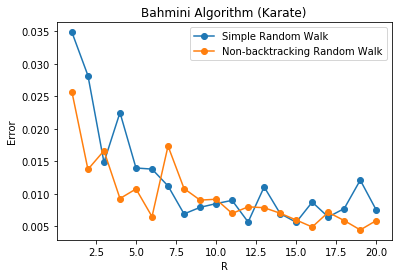

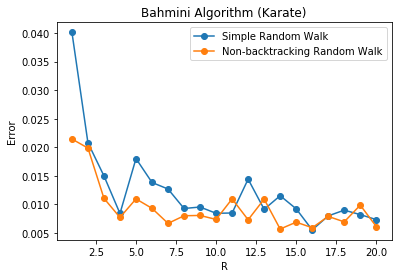

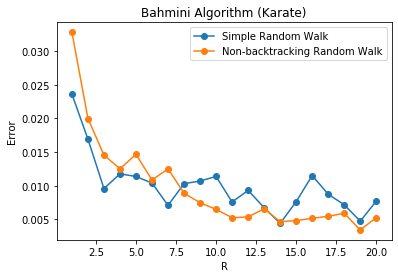

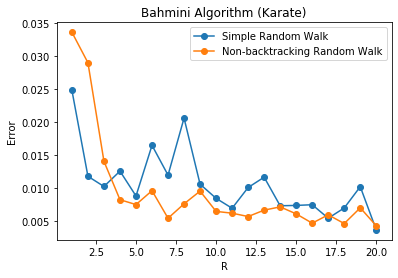

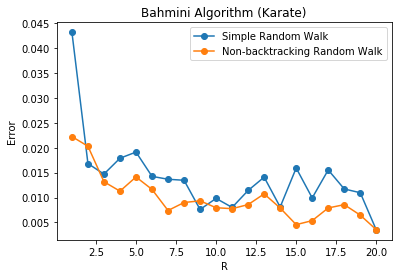

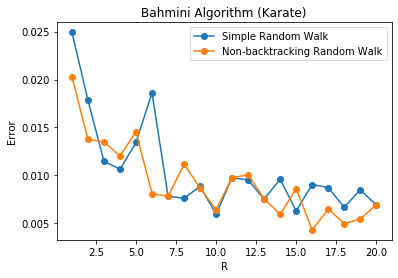

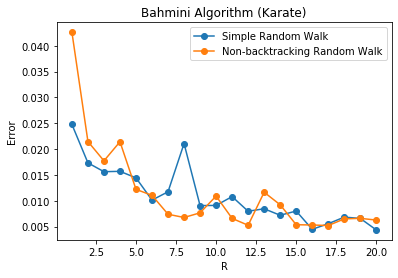

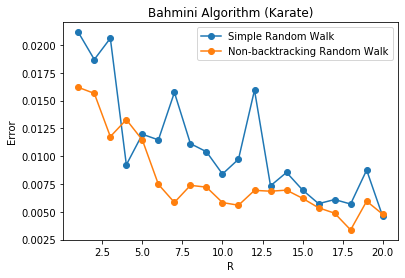

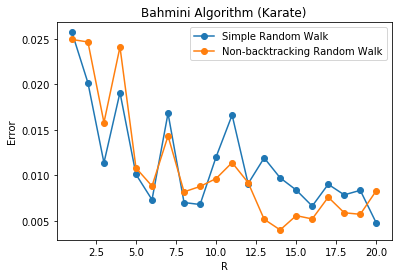

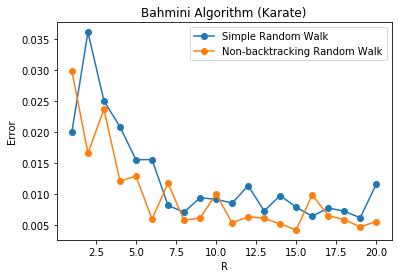

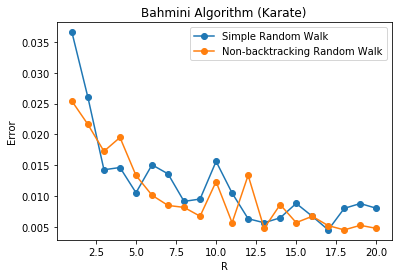

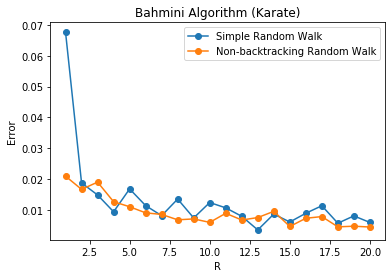

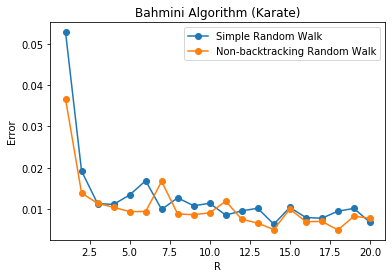

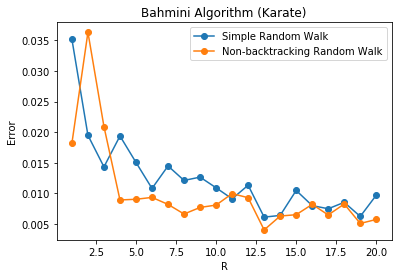

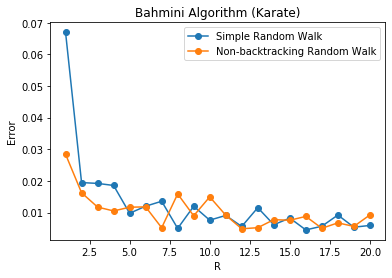

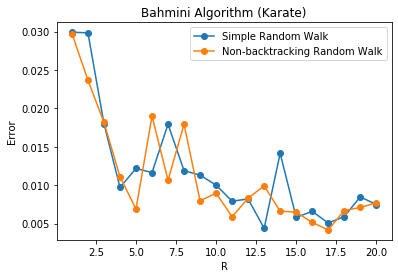

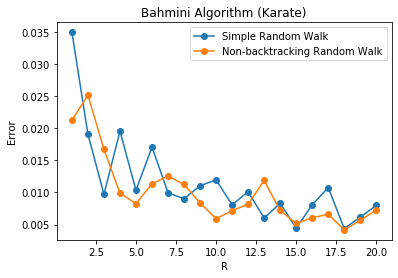

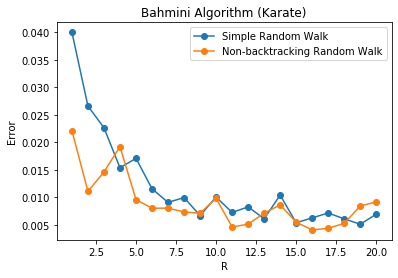

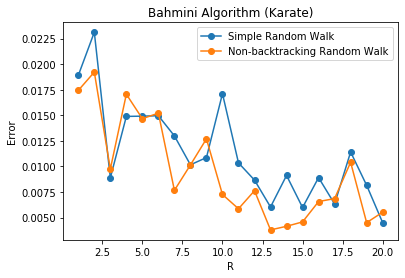

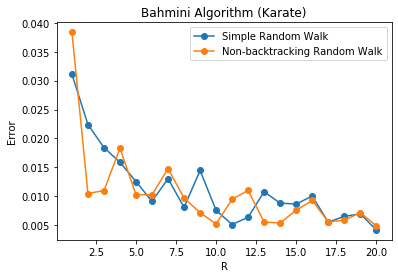

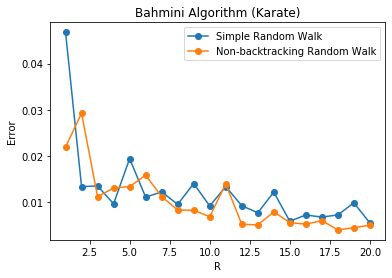

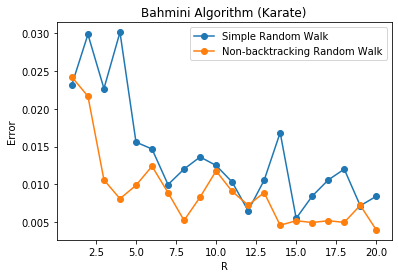

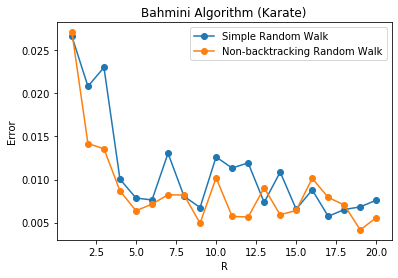

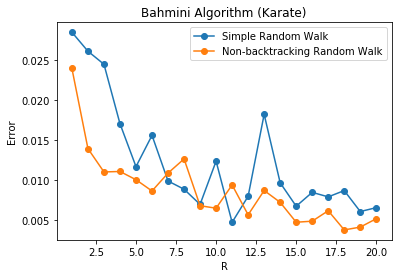

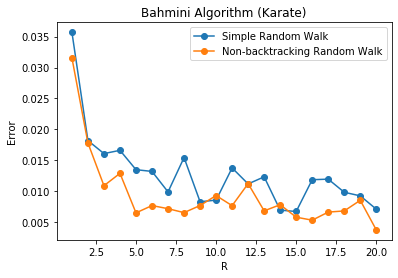

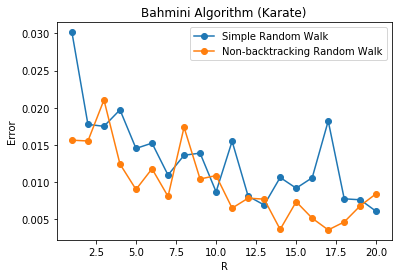

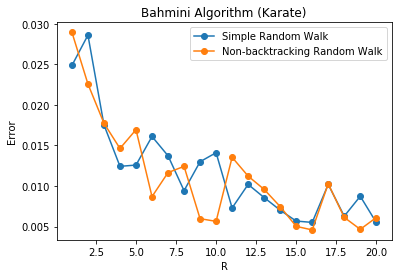

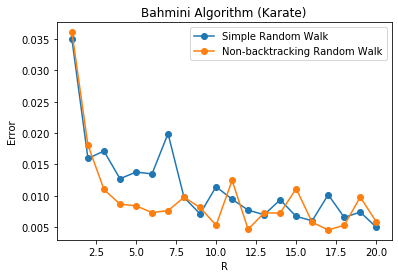

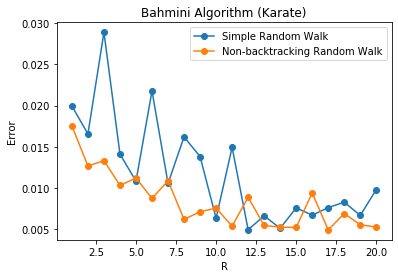

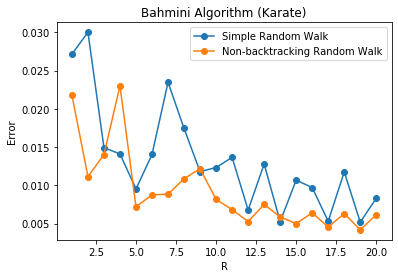

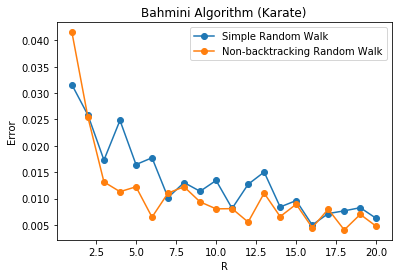

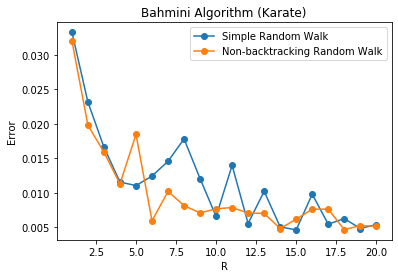

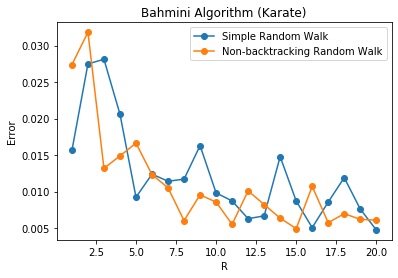

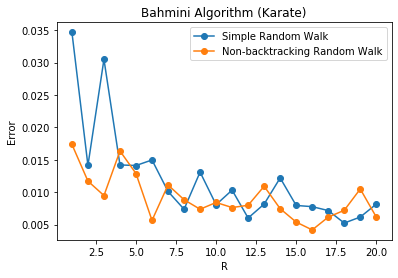

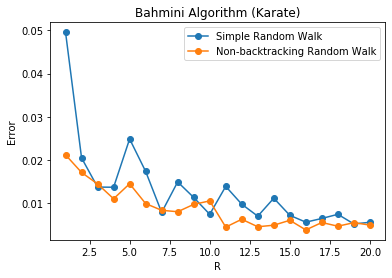

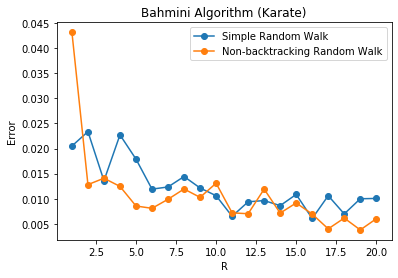

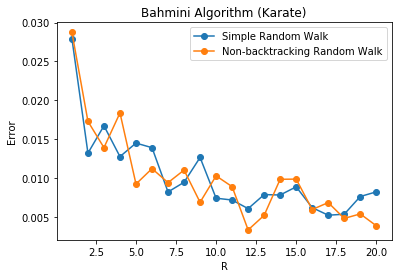

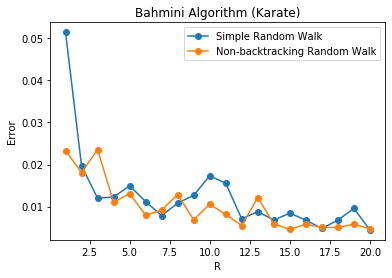

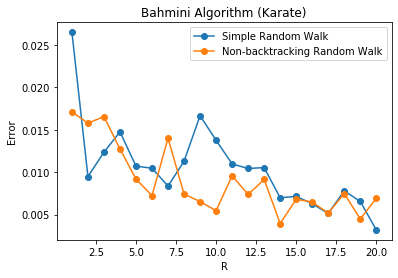

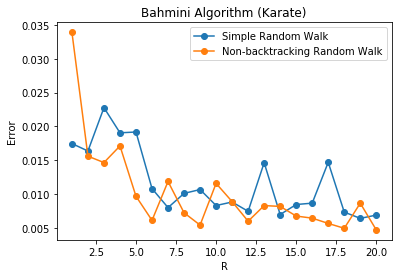

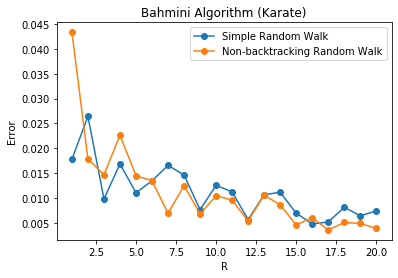

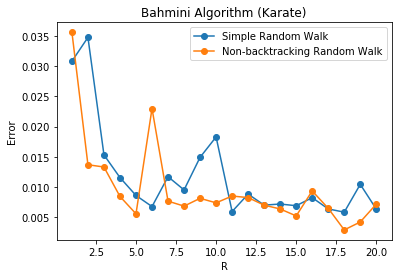

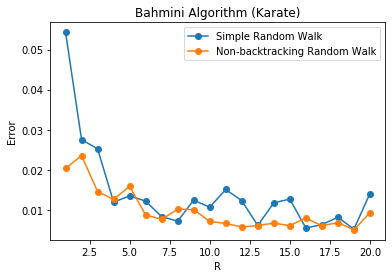

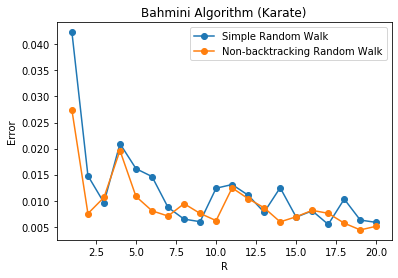

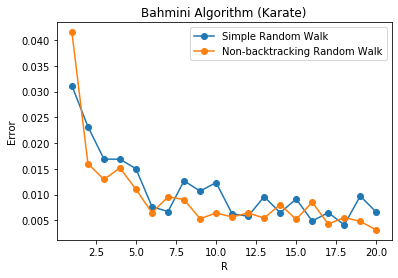

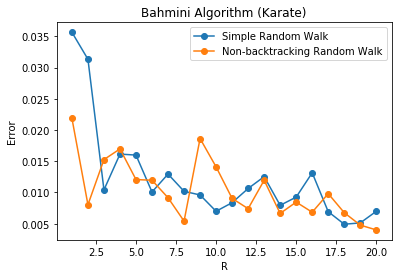

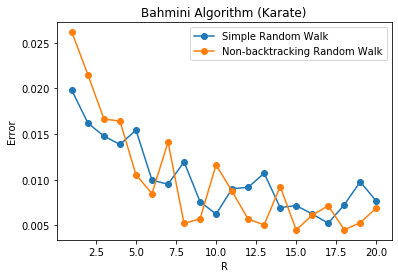

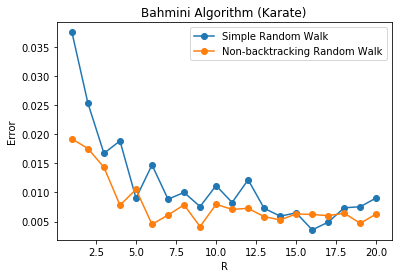

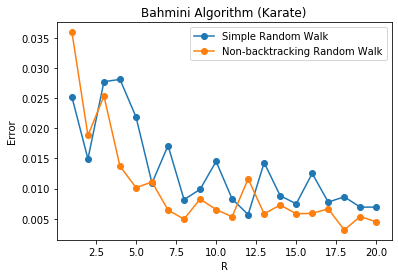

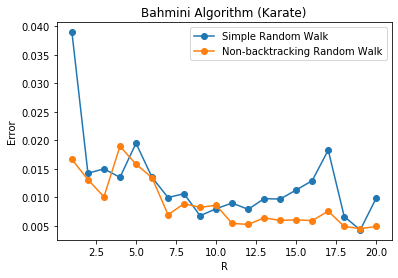

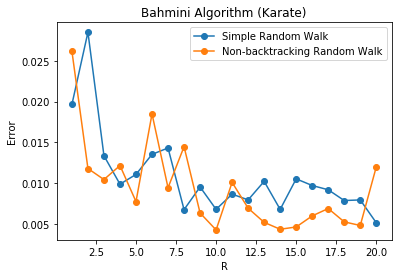

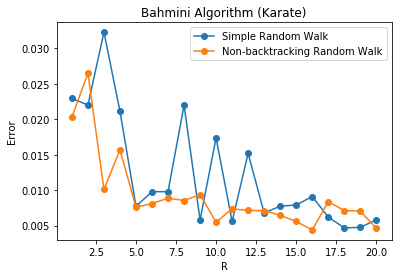

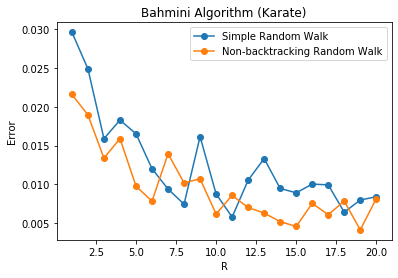

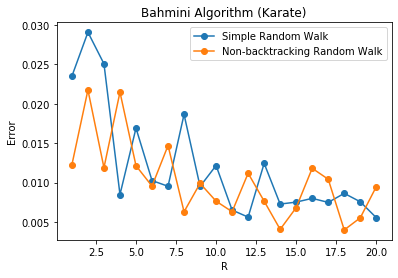

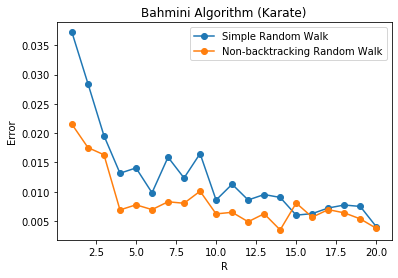

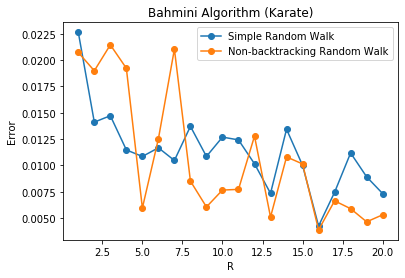

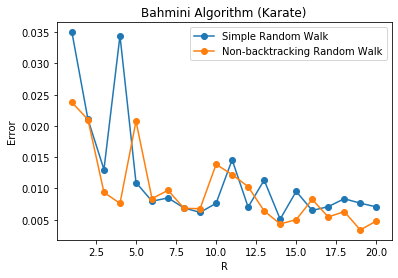

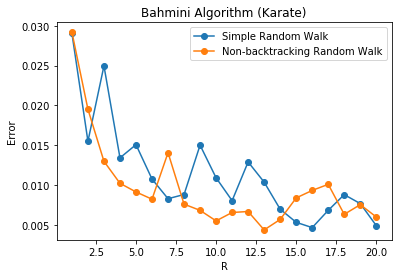

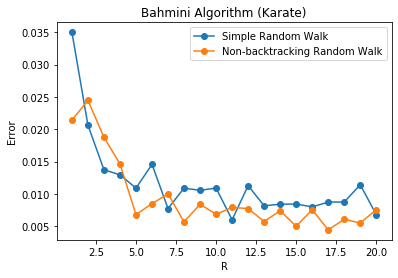

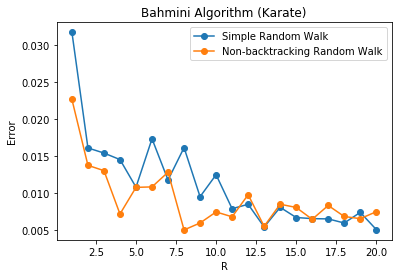

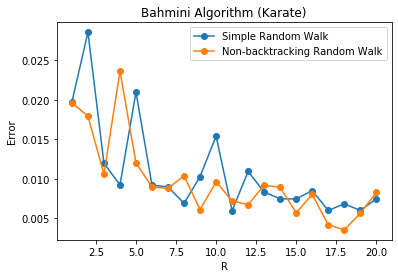

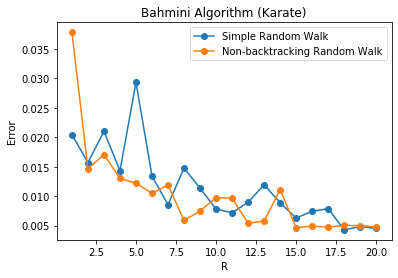

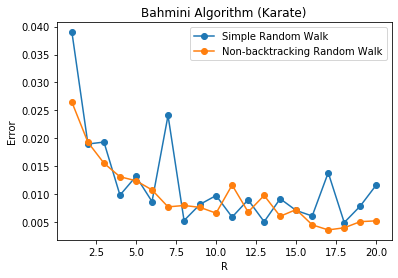

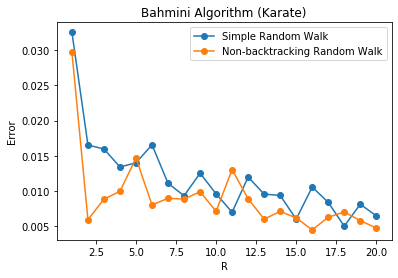

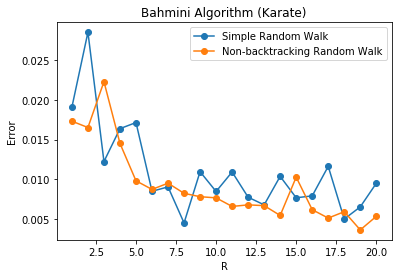

In [93]:
pr_array = np.zeros((20,100))
nb_array = np.zeros((20,100))
for i in range(100):
    pr, nb_pr = pr_alg_test(R_list,G,nb_vec=nb_vec)
    pr_array[:,i] = pr
    nb_array[:,i] = nb_pr

In [27]:
avg_pr = np.mean(pr_array,axis=1)
avg_nb = np.mean(nb_array,axis=1)

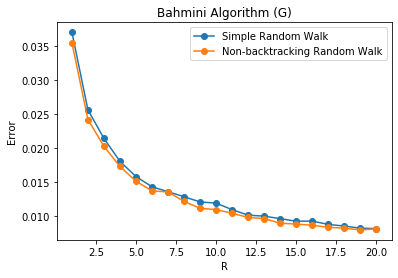

In [29]:
plt.plot(R_list,avg_pr,'-o',label='Simple Random Walk')
plt.plot(R_list,avg_nb,'-o',label='Non-backtracking Random Walk')
# plt.loglog(R_list,[vals_pr[0]*i**(-vals_pr[1]) for i in R_list],label="Fitted Simple")
# plt.loglog(R_list,[vals_nb[0]*i**(-vals_nb[1]) for i in R_list],label="Fitted NB")
plt.legend()
plt.xlabel('R')
plt.ylabel('Error')
plt.title('Bahmini Algorithm (G)')
# plt.savefig('power_law_karate.pdf')
plt.show()

In [95]:
def fitted(x,c,alpha):
    return c*x**(-alpha)

In [96]:
vals_pr, covar_pr = curve_fit(fitted,R_list,avg_pr)
vals_nb, covar_nb = curve_fit(fitted,R_list,avg_nb)

In [97]:
abs(vals_pr[0]-vals_nb[0])

0.0051961270281024735

In [27]:
G = nx.read_gml('football/football.gml')

In [133]:
R_list = [i for i in range(1,21)]

In [32]:
# Calculate nb
obj_G = PageRankAlg(G)
nb_vec = obj_G.nb_pagerank()

In [135]:
def pr_alg_test(R_list,G=None,pr_vec = None,nb_vec=None):
    """
    Compare accuarcy for various values of R in 
    Bahmini alg with and without non-backtracking
    condition
    
    Parameters:
        R_list (ndarray): array of R values to test
        G (networkx graph)
        pr_vec (ndarray): pagerank vector
        nb_vec (ndarray): nb pagerank vector
        
    Returns:
        bac_acc (ndarray): array of KT correlations for simple
                           random walks
        nb_bah_acc (ndarray): array of KT correlations for 
                              non-backtracking random walks
    """
#     # Create random graph if none given
#     if G is None:
#         G = nx.gnp_random_graph(100,.7)
        
#     # Initialize object and accuracy lists
    g = PageRankAlg(G)
    bah_acc = []
    nb_acc = []
    
#     # Get original pagerank
    pr = g.pagerank()
#     nb_pr_v = g.nb_pagerank()
# #     nb_pr_v = vec
    pr = np.array(list(pr.values()))
    nb = np.array(list(nb_vec.values()))

    for i, r in enumerate(R_list):
        # Calculate accuracy of bahmini and nb bahmini
        bah = np.array(list(g.bahmini_alg(r).values()))
        nb_bah = np.array(list(g.nb_bahmini_alg(r).values()))
        bah_acc.append(la.norm(bah-pr,ord=np.inf))
        nb_acc.append(la.norm(nb_bah-nb,ord=np.inf))
    
    # Plot R vs. accuracy
    plt.loglog(R_list,bah_acc,'-o',label='Simple Random Walk')
    plt.loglog(R_list,nb_acc,'-o',label='Non-backtracking Random Walk')
    plt.legend()
    plt.xlabel('R')
    plt.ylabel('Error')
    plt.title('Bahmini Algorithm')
#     plt.savefig('power_law.pdf')
    plt.show()
    
    return bah_acc, nb_acc

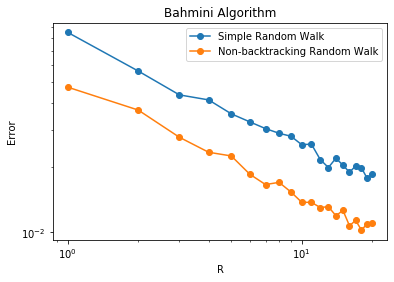

In [137]:
plt.loglog(R_list,avg_pr,'-o',label='Simple Random Walk')
plt.loglog(R_list,avg_nb,'-o',label='Non-backtracking Random Walk')
plt.loglog(R_list,[.09*i**(-.55) for i in R_list],'-o')
plt.legend()
plt.xlabel('R')
plt.ylabel('Error')
plt.title('Bahmini Algorithm')
# plt.savefig('bahmini_comparison_football.pdf')
plt.show()

In [110]:
alpha

1.3558810043245506

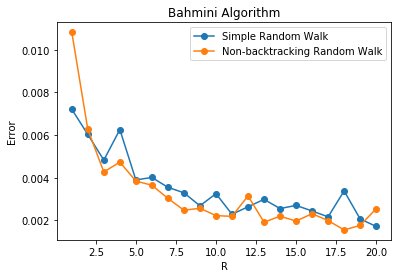

([0.007213388096654302,
  0.006031662403522899,
  0.00482867103799323,
  0.006261540870145566,
  0.0038986845566641067,
  0.004015153154132322,
  0.0035523600237955377,
  0.0032953450936422275,
  0.0026866010318159494,
  0.003255495851050047,
  0.0022876827578044235,
  0.002638178728141512,
  0.0029878186530654244,
  0.0025556173946987507,
  0.00270461405308816,
  0.002442428823024043,
  0.0021678409443178816,
  0.0033828574506966514,
  0.002070255672432582,
  0.001718126010207906],
 [0.010826336446651392,
  0.006268654567258884,
  0.004273602260150628,
  0.004735278466088105,
  0.0038471019418538826,
  0.0036501058012862256,
  0.0030340470449003697,
  0.0024785129142724967,
  0.002568647466393693,
  0.0022262171921504483,
  0.002189585414590741,
  0.00314901843033512,
  0.0019160293244767784,
  0.0021971021209942227,
  0.0019694491915930113,
  0.002315157419248797,
  0.0019922846923411458,
  0.0015543197870826041,
  0.001765948282749296,
  0.002549504945407212])

In [139]:
pr_alg_test(R_list,G)
# 2 norm

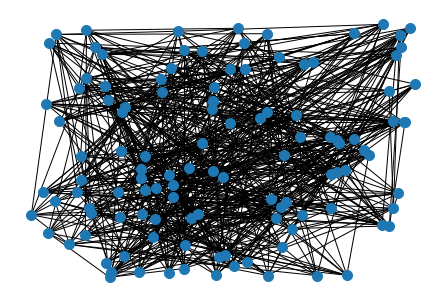

In [104]:
nx.draw_random(G,node_size=100)
plt.savefig('football.pdf')
plt.show()

In [105]:
alpha = 1+20*np.sum([np.log(2*r) for r in R_list])**(-1)

In [12]:
test = PageRankAlg(G)

In [14]:
vec = test.nb_pagerank()

In [50]:
pr = test.pagerank()

In [51]:
C, B = nb.to_edge_space(G, B=True, graph=False)
S, T = nb.create_s_t(G)

# Get edge degree matrix
D = np.diag(B.sum(axis=1))
D_inv = la.solve(D,np.eye(D.shape[0]))

In [79]:
nb_over_d = la.solve(np.diag(np.array(A.sum(axis=1).reshape(115,))[0,:]),np.eye(115))@np.array(list(vec.values()))

In [80]:
nb_over_d/np.sum(nb_over_d)

array([0.00851801, 0.00856103, 0.00845626, 0.00854154, 0.00860679,
       0.00858782, 0.00848726, 0.00844113, 0.00856894, 0.00856245,
       0.00873855, 0.00886186, 0.00889845, 0.00855667, 0.00884368,
       0.00845715, 0.00857388, 0.00872066, 0.00881663, 0.0087104 ,
       0.00873088, 0.00854288, 0.00854252, 0.00858381, 0.00883055,
       0.00862642, 0.00890827, 0.00873541, 0.00899991, 0.00870396,
       0.00867066, 0.00872069, 0.00853247, 0.00874215, 0.00879074,
       0.00865453, 0.00923176, 0.00868856, 0.00876324, 0.00856556,
       0.00859201, 0.00865829, 0.00946595, 0.00882644, 0.0086821 ,
       0.0086351 , 0.00848011, 0.00852842, 0.00864706, 0.00849269,
       0.00896261, 0.00859425, 0.00871248, 0.0084264 , 0.0088247 ,
       0.00865502, 0.00881213, 0.0088511 , 0.00888628, 0.00928895,
       0.00860822, 0.00871792, 0.0086928 , 0.00911496, 0.00856806,
       0.00872364, 0.00873402, 0.00839903, 0.00855251, 0.0087091 ,
       0.00871969, 0.00882394, 0.00860288, 0.00847738, 0.00857

In [92]:
np.var(np.divide(np.array(list(vec.values())),np.array(list(pr.values()))))

4.008470859593282e-06

In [114]:
def check_var(G=None,pr=None,nb_pr=None):
    cur = PageRankAlg(G)
    if pr is None:
        pr = cur.pagerank()
    if nb_pr is None:
        nb_pr = cur.nb_pagerank()
    ratio = np.divide(np.array(list(nb_pr.values())),np.array(list(pr.values())))
    return np.var(ratio), np.var(np.array([i[1] for i in list(G.degree())])), plt.hist(np.array(list(pr.values()))-np.array(list(nb_pr.values())))
    

(4.008470859593282e-06,
 0.7806427221172025,
 (array([ 8., 13., 21., 20., 23., 11., 13.,  1.,  1.,  4.]),
  array([-3.05821722e-05, -2.27936879e-05, -1.50052037e-05, -7.21671941e-06,
          5.71764854e-07,  8.36024912e-06,  1.61487334e-05,  2.39372177e-05,
          3.17257019e-05,  3.95141862e-05,  4.73026705e-05]),
  <a list of 10 Patch objects>))

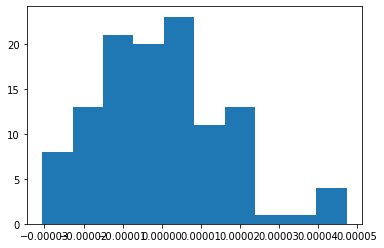

In [115]:
check_var(G,nb_pr=vec)

In [117]:
for r in range(10):
    cur = PageRankAlg()
    pr = cur.pagerank()
    nb_pr = cur.nb_pagerank()
    plt.hist(np.array(list(pr.values()))-np.array(list(nb_pr.values())))
    print(len(cur.G.nodes()))
    print(len(cur.G.edges()))
    plt.show()

KeyboardInterrupt: 

In [103]:
list(G.degree())

[('BrighamYoung', 12),
 ('FloridaState', 12),
 ('Iowa', 12),
 ('KansasState', 12),
 ('NewMexico', 11),
 ('TexasTech', 12),
 ('PennState', 12),
 ('SouthernCalifornia', 12),
 ('ArizonaState', 11),
 ('SanDiegoState', 11),
 ('Baylor', 10),
 ('NorthTexas', 10),
 ('NorthernIllinois', 10),
 ('Northwestern', 11),
 ('WesternMichigan', 10),
 ('Wisconsin', 12),
 ('Wyoming', 11),
 ('Auburn', 11),
 ('Akron', 11),
 ('VirginiaTech', 11),
 ('Alabama', 11),
 ('UCLA', 11),
 ('Arizona', 11),
 ('Utah', 11),
 ('ArkansasState', 10),
 ('NorthCarolinaState', 11),
 ('BallState', 10),
 ('Florida', 11),
 ('BoiseState', 9),
 ('BostonCollege', 11),
 ('WestVirginia', 11),
 ('BowlingGreenState', 11),
 ('Michigan', 11),
 ('Virginia', 10),
 ('Buffalo', 11),
 ('Syracuse', 11),
 ('CentralFlorida', 8),
 ('GeorgiaTech', 11),
 ('CentralMichigan', 11),
 ('Purdue', 11),
 ('Colorado', 11),
 ('ColoradoState', 10),
 ('Connecticut', 7),
 ('EasternMichigan', 11),
 ('EastCarolina', 11),
 ('Duke', 11),
 ('FresnoState', 11),
 ('Ohio

In [59]:
A = nx.adjacency_matrix(G).todense()

In [76]:
la.solve(np.diag(np.array(A.sum(axis=1).reshape(115,))[0,:]),np.eye(115))

array([[0.08333333, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.08333333, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.08333333, ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.1       , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.1       ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09090909]])

### Large n

In [7]:
random = nx.gnp_random_graph(500,.5)

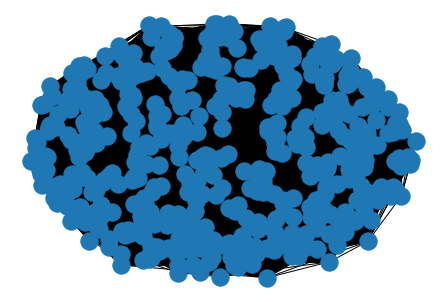

In [8]:
nx.draw(random)

In [ ]:
R_list = [i for i in range(1,5)]

In [12]:
nb_vec = PageRankAlg(random).nb_pagerank()

KeyboardInterrupt: 

In [ ]:
pr_est, nb_est = pr_alg_test(R_list,G,nb_vec=nb_vec)